In [1]:
!pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 26.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim
import tqdm
import optuna
from optuna.importance import get_param_importances

c:\Users\55199\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configurações
BATCH_SIZE = 64
IMG_SIZE = 28
NUM_CHANNELS = 1
NUM_CLASSES = 10
LATENT_DIM = 128
LEARNING_RATE = 0.002
BETA1, BETA2 = 0.5, 0.9
EPOCHS = 5
MODEL_PATH = f"wgan_{EPOCHS}e_{BATCH_SIZE}b_{LEARNING_RATE}lr_{BETA1}B1{BETA2}B2_.pth"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Transformação para normalizar imagens entre [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregar dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
classes = train_dataset.classes

In [7]:
# Camada de Convolução para o Discriminador
def conv_block(in_channels, out_channels, kernel_size=5, stride=2, padding=2, use_bn=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

In [8]:
# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(NUM_CHANNELS + NUM_CLASSES, 64, use_bn=False),
            conv_block(64, 128, use_bn=True),
            conv_block(128, 256, use_bn=True),
            conv_block(256, 512, use_bn=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Camada de upsample para o Gerador
def upsample_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True):
    layers = [
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    return nn.Sequential(*layers)

In [12]:
# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            upsample_block(256, 128),
            upsample_block(128, 64),
            upsample_block(64, 32),
            nn.Conv2d(32, NUM_CHANNELS, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [13]:
# Inicializar modelos
D = Discriminator().to(device)
G = Generator().to(device)

In [99]:
# Otimizadores
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [14]:
 # Função de perda Wasserstein
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

In [15]:
# Função para calcular Gradient Penalty
def gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(d_interpolated),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [20]:
# Função Objetiva (a ser otimizada pelo Optuna)
def objective(trial):
    # Escolher os hiperparâmetros dentro de um intervalo
    batch_size = trial.suggest_categorical("batch_size", [16, 128])
    latent_dim = trial.suggest_categorical("latent_dim", [10, 256])
    lr = trial.suggest_float("learning_rate", 0.0001, 0.005, log=True)
    beta1 = trial.suggest_float("beta1", 0.0, 0.9)
    beta2 = trial.suggest_float("beta2", 0.8, 0.999)
    gp_scale = trial.suggest_int("gp_scale", 0, 100)

    # Criar DataLoader com batch_size otimizado
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Criar novos modelos e otimizadores
    D = Discriminator().to(device)
    G = Generator(latent_dim=latent_dim).to(device)
    optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

    G.train()
    D.train()

    total_loss = 0.0
    total_batches = 0

    # Treinar por algumas épocas
    for epoch in range(3):
        epoch_loss = 0.0
        epoch_batches = 0
        progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for real_images, labels in progress_bar:
            real_images = real_images.to(device)
            labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)

            image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, IMG_SIZE, IMG_SIZE)
            real_images = torch.cat([real_images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z).detach()
            fake_images = torch.cat([fake_images, image_labels], dim=1)

            optimizer_D.zero_grad()
            loss_D = discriminator_loss(D(real_images), D(fake_images)) + gp_scale * gradient_penalty(D, real_images, fake_images)
            loss_D.backward()
            optimizer_D.step()

            # Treinar Gerador
            optimizer_G.zero_grad()
            z = torch.randn(real_images.size(0),latent_dim).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_labels], dim=1)))
            loss_G.backward()
            optimizer_G.step()

            epoch_loss += loss_G.item()
            total_loss += loss_G.item()
            total_batches += 1
            epoch_batches += 1

            progress_bar.set_postfix(d_loss=loss_D.item(), g_loss=loss_G.item())

        # Calcular a loss média dessa época
        epoch_avg_loss = epoch_loss / epoch_batches
        # Reporta a loss média da época para pruning
        trial.report(epoch_avg_loss, epoch)
        if trial.should_prune() and epoch >=3:
            raise optuna.exceptions.TrialPruned()
            

    avg_loss = total_loss / total_batches

    return avg_loss  # Optuna tentará minimizar essa métrica

# Criar estudo do Optuna e otimizar hiperparâmetros
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# Exibir os melhores hiperparâmetros encontrados
print("\n🔹 Melhores Hiperparâmetros Encontrados:")
print(study.best_params)

importance = get_param_importances(study)
print("Hyperparameter Importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")

[I 2025-02-19 11:51:46,007] A new study created in memory with name: no-name-96456994-9dd2-42af-b160-7c6f481e8400
Epoch 3/5: 100%|██████████| 3750/3750 [02:51<00:00, 21.86it/s, d_loss=-0.0284, g_loss=-2.59]  
[I 2025-02-19 11:59:58,309] Trial 0 finished with value: -2.729246115597089 and parameters: {'batch_size': 16, 'latent_dim': 256, 'learning_rate': 0.0014815568126483147, 'beta1': 0.4199748968333889, 'beta2': 0.8634643054973907, 'gp_scale': 58}. Best is trial 0 with value: -2.729246115597089.
Epoch 3/5: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s, d_loss=0.0148, g_loss=-6.51]   
[I 2025-02-19 12:02:58,765] Trial 1 finished with value: -5.718030814761885 and parameters: {'batch_size': 128, 'latent_dim': 10, 'learning_rate': 0.0008912270154794811, 'beta1': 0.15827296634519158, 'beta2': 0.8937092249525379, 'gp_scale': 17}. Best is trial 1 with value: -5.718030814761885.
Epoch 3/5: 100%|██████████| 3750/3750 [02:44<00:00, 22.85it/s, d_loss=-0.816, g_loss=2.1]     
[I 2025-02-19 12


🔹 Melhores Hiperparâmetros Encontrados:
{'batch_size': 128, 'latent_dim': 10, 'learning_rate': 0.0008912270154794811, 'beta1': 0.15827296634519158, 'beta2': 0.8937092249525379, 'gp_scale': 17}


NameError: name 'get_param_importances' is not defined

In [23]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------------------------------- ---- 9.7/11.1 MB 48.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 38.7 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   ------ --------------------------------- 6.3/41.0 MB 57.2 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/41.0 MB 36.3 MB/s eta 0:00:01
   --------------------- ------------------ 22.3/41.0 MB 40.3 MB/s eta 0:00:01
   ------------------------- -------------- 25.7/41.0 MB 31.5 MB/s eta 0:00:01
   ---------------------------------- ----- 35.4/41.0 MB 34.9 MB/s eta 0:00:01
   ---------------------------------------- 41.0


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
!python -m pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [26]:
importance = get_param_importances(study)
print("Hyperparameter Importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")

ImportError: Tried to import 'sklearn' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'sklearn'.

In [102]:
# Treinamento
for epoch in range(EPOCHS):
    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    progress_bar = tqdm.tqdm(train_loader, desc=f"Treinando {epoch+1}/{EPOCHS}", leave=True)

    for real_images, labels in progress_bar:
        real_images = real_images.to(device)
        labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
        # Adicionar labels ao real_images para treinamento do Discriminador
        image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, IMG_SIZE, IMG_SIZE)
        real_images = torch.cat([real_images, image_labels], dim=1)

        # Treinar Discriminador
        z = torch.randn(real_images.size(0), LATENT_DIM).to(device)
        z = torch.cat([z, labels], dim=1)
        fake_images = G(z).detach()
        fake_images = torch.cat([fake_images, image_labels], dim=1)

        optimizer_D.zero_grad() 
        D(real_images)
        loss_D = discriminator_loss(D(real_images), D(fake_images)) + 10 * gradient_penalty(D, real_images, fake_images)
        loss_D.backward()
        optimizer_D.step()

        # Treinar Gerador
        if epoch % 3 == 0:
            optimizer_G.zero_grad()
            z = torch.randn(real_images.size(0), LATENT_DIM).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_labels], dim=1)))
            loss_G.backward()
            optimizer_G.step()

        progress_bar.set_postfix(d_loss=loss_D.item(), g_loss=loss_G.item())

    # Salvar modelo a cada época
    torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, CHECKPOINT_PATH)

print("✅ Treinamento Concluído!")


🔹 Epoch 1/5


Treinando 1/5: 100%|██████████| 938/938 [02:13<00:00,  7.02it/s, d_loss=-0.336, g_loss=10.9]   



🔹 Epoch 2/5


Treinando 2/5: 100%|██████████| 938/938 [01:34<00:00,  9.89it/s, d_loss=-10.2, g_loss=10.9] 



🔹 Epoch 3/5


Treinando 3/5: 100%|██████████| 938/938 [01:40<00:00,  9.33it/s, d_loss=-11.3, g_loss=10.9] 



🔹 Epoch 4/5


Treinando 4/5: 100%|██████████| 938/938 [02:06<00:00,  7.43it/s, d_loss=-0.0144, g_loss=36.3] 



🔹 Epoch 5/5


Treinando 5/5: 100%|██████████| 938/938 [01:38<00:00,  9.53it/s, d_loss=-8.01, g_loss=36.3]   


✅ Treinamento Concluído!


In [103]:
import matplotlib.pyplot as plt

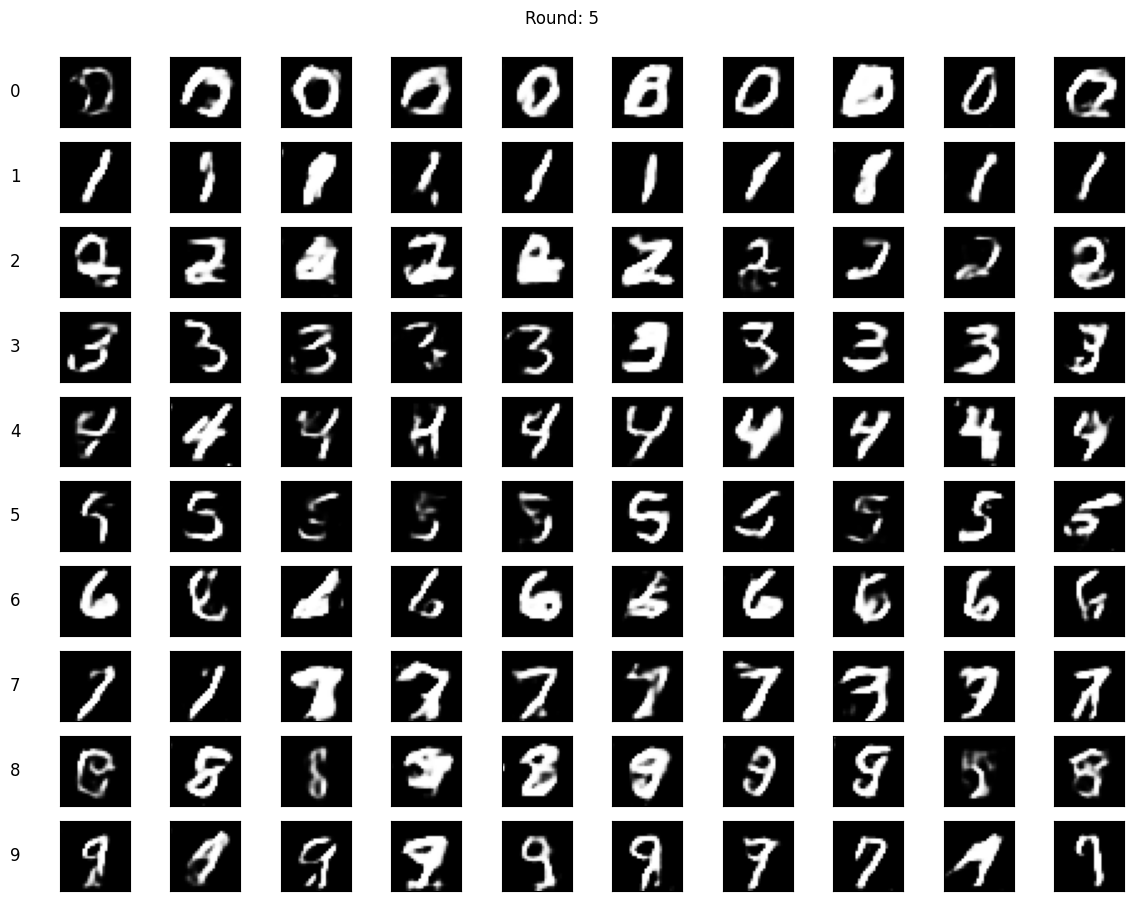

In [104]:
seed = 42
device = "cpu"
# random.seed(seed)
# np.random.seed(seed)
#torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
G.to(device)
path = ""
# Assuming netG is your generator model, classes is the total number of classes, and latent_dim is the latent vector size
examples_per_class = 10
classes = 10
batch_size = examples_per_class * classes  # Generate enough images to have `examples_per_class` for each class

# Generate latent vectors and corresponding labels
latent_vectors = torch.randn(batch_size, LATENT_DIM, device=device)
labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)
labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)

# Generate images
with torch.no_grad():
    generated_images = G(torch.cat([latent_vectors, labels], dim=1))

# Criar uma figura com 10 linhas e 5 colunas de subplots
fig, axes = plt.subplots(classes, examples_per_class, figsize=(12, 9))

#fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)

fig.text(0.5, 0.98, f"Round: {5}", ha="center", fontsize=12)

# Exibir as imagens nos subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0, :, :], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar o layout antes de calcular as posições
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Reduzir espaço entre colunas
# plt.subplots_adjust(wspace=0.05)

# Adicionar os rótulos das classes corretamente alinhados
fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
for row in range(classes):
    # Obter posição do subplot em coordenadas da figura
    bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
    pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

    # Adicionar o rótulo
    fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')
    plt.savefig(f"{path}WGAN_{EPOCHS}e_{BATCH_SIZE}b_{LEARNING_RATE}lr_{BETA1}B1_{BETA2}B2.png")